In [ ]:

import numpy as np
from DeepQLearning.generate_price_data import *
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from itertools import product
from constructing_models import *

This part is the exact same as the simple DQN notebook (just constructing initial parameters and generating data)

84
color green: low vol
color yellow: medium vol
color red: high vol


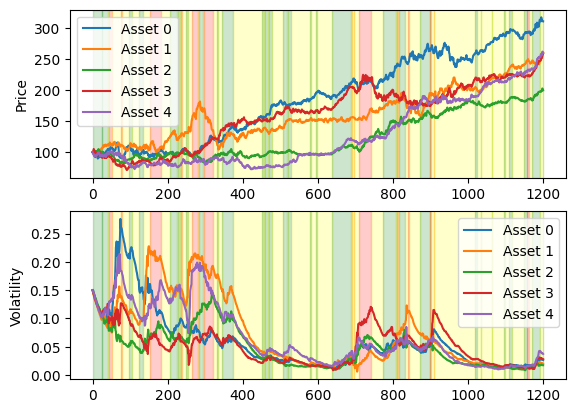

In [38]:
a = 5 # size of action space
n = 5 # num asssets

# shape (n, a)
A = np.random.dirichlet(np.full(n, 1), a)


m = 3 # action space
M = np.array([
    [0.95, 0.05, 0.00],
    [0.06, 0.91, 0.03],
    [0.00, 0.12, 0.88]
])

init_regime_prob_dist = [0.7, 0.15, 0.15]

T = 1000
T_test = 200

regime = np.random.choice(range(m), p=init_regime_prob_dist)
true_regimes_total = np.empty(T + T_test, dtype=int)
true_regimes_total[0] = regime
for t in range(1, T + T_test):
    next_regime = np.random.choice(range(m), p=M[regime, :])
    true_regimes_total[t] = next_regime
    regime = next_regime


price_data_total = np.empty((T + T_test, n))
volatility_data_total = np.empty((T + T_test, n))

xi_values = [0.05, 0.2, 0.6] # volatility of volatility
kappa_values = [6, 1.0, 0.5] # mean reversion rate
theta_values = [0.01, 0.2, 1.2] # mean volatility
mu_values = [0.0, 1.0, -1.0] # price drift

V0 = np.full(n, 0.15)
S0 = np.full(n, 100)

price_data_total = np.empty((T + T_test, n))
volatility_data_total = np.empty((T + T_test, n))

fig, (ax1, ax2) = plt.subplots(2)

x_breakpoints = []
x_breakpoints_labels = []

t = 0
while t < T + T_test:
    this_regime = true_regimes_total[t]
    tt = t + 1
    while tt < T + T_test:
        if true_regimes_total[tt] == this_regime:
            tt += 1
        else:
            break
    x_breakpoints.append(tt)
    x_breakpoints_labels.append(this_regime)
    volatility_data_total[t:tt, :] = np.array([
            generate_volatility(
                V0=V0[i],
                xi=xi_values[this_regime],
                theta=theta_values[this_regime],
                kappa=kappa_values[this_regime],
                N=tt - t,
                dt=1/365
            )
            for i in range(n)
        ]).T
    price_data_total[t:tt, :] = np.array([
        generate_prices(
            vola_values=volatility_data_total[t:tt, i],
            S0=S0[i],
            N=tt - t,
            mu=mu_values[this_regime],
            dt=1/365
    )
        for i in range(n)
    ]).T
    V0 = volatility_data_total[tt - 1, :]
    S0 = price_data_total[tt - 1, :]
    t = tt

x_breakpoints_labels.append(this_regime)
x_breakpoints.append(t)

price_data = price_data_total[:T]
price_data_eval = price_data_total[T:]
volatility_data = volatility_data_total[:T]
volatility_data_data_eval = volatility_data_total[T:]

for i in range(a):
    ax1.plot(range(T + T_test), price_data_total[:, i], label=f"Asset {i}")
    ax2.plot(range(T + T_test), volatility_data_total[:, i], label=f"Asset {i}")

ax1.legend()
ax2.legend()
ax1.set_ylabel("Price")
ax2.set_ylabel("Volatility")

colors = ["green", "yellow", "red"]
color_labels = ["low vol", "medium vol", "high vol"]

for i in range(len(x_breakpoints) - 1):
    ax1.axvspan(x_breakpoints[i],
                x_breakpoints[i + 1], color=colors[x_breakpoints_labels[i]],
                alpha=0.2)
    ax2.axvspan(x_breakpoints[i],
                x_breakpoints[i + 1], color=colors[x_breakpoints_labels[i]],
                alpha=0.2)

true_regimes = true_regimes_total[:T]
true_regimes_eval = true_regimes_total[T:]

ax1.axvspan(0, x_breakpoints[0], color=colors[true_regimes[0]], alpha=0.2)
ax2.axvspan(0, x_breakpoints[0], color=colors[true_regimes[0]], alpha=0.2)

print(len(x_breakpoints_labels))

for c, cl in zip(colors, color_labels):
    print(f"color {c}: {cl}")

plt.show()

In [42]:
total_returns = pd.DataFrame(price_data_total).pct_change(axis=0).to_numpy()
returns_train = total_returns[:T]
returns_train[0, :] = np.zeros(n)

# construct returns and volatility data 
vola_lookback = 15
mean_returns = np.mean(returns_train, axis=1)
vola = pd.Series(mean_returns).rolling(vola_lookback, min_periods=1).std().values
vola[0] = 0


C:\Users\tobia\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\tobia\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s

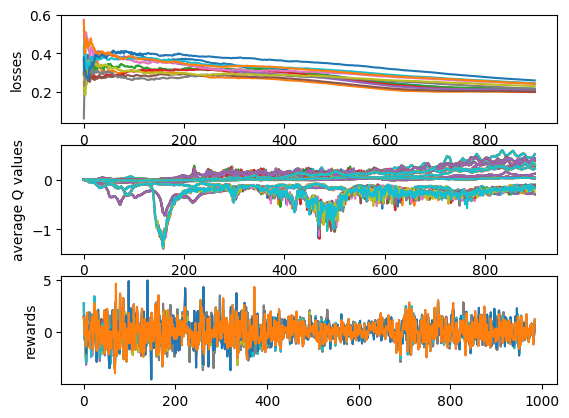

In [ ]:
rb_capacity = [200, 500]
rb_sample_size = [5, 10]
gamma = [0.95]
t_replay_buffer = [100]
training_lookback_period = [15]
model_constructors = [construct_dqn_1, construct_dqn_2, construct_dqn_3]
target_update_freq = [50]
action_space = [A]
state_space = [returns_train]


product_args = list(product(state_space, rb_capacity, rb_sample_size, action_space, gamma, target_update_freq, training_lookback_period, t_replay_buffer, model_constructors))
tester = Tester(*product_args)

# train all
tester.train_all()
tester.show_stats()
